<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

Итак, в данном проекте у нас представлены данные о клиентах банка с рядом персонифицированных признаков.
Целью данного проекта является прогнозирование ухода (в близжайшее время) клиента по имеющимся данным.
В целом план работ по данному проекту представляется целесообразным составить следующим образом:
* первичный обзор данных;
* подготовка данных, включая поиск дубликатов, преобразование типов данных и отсутствующих значений;
* преобразование категориальных переменных, а также осуществление масштабирования вещественных переменных;
* первичное применение моделей машинного обучения и обзор результатов;
* (при необходимости) корректировка вышеуказанных действий.

## Подготовка данных

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import random
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import f1_score, roc_auc_score, plot_roc_curve
from sklearn.utils import shuffle
from sklearn.ensemble import GradientBoostingClassifier

import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('Churn.csv', index_col=['RowNumber', 'CustomerId'])
df.drop('Surname', axis=1, inplace=True) # уберем фамилию как несущественную переменную
# столбец RowNumber, очевидно, не несет в себе информационной нагрузки в данном случае,
# однако, учитывая, что все значения в CustomerId - уникальны,
# то указанное выше - справедливо и для него
df.head()

,,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,CustomerId,,,,,,,,,,,
1,15634602,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
2,15647311,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
3,15619304,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
4,15701354,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
5,15737888,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [2]:
df.describe(include='all')

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000,10000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
unique,NaN,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,France,Male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,5014,5457,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,650.528800,NaN,NaN,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,NaN,NaN,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,NaN,NaN,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,NaN,NaN,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,NaN,NaN,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,NaN,NaN,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000


In [3]:
df.duplicated().sum()

0

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10000 entries, (1, 15634602) to (10000, 15628319)
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           9091 non-null   float64
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 1.5+ MB


<AxesSubplot: >

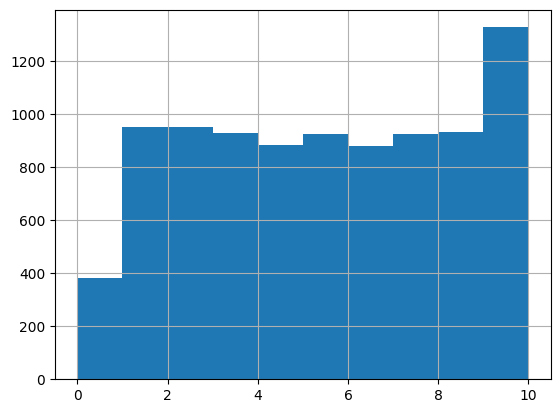

In [5]:
# переменная Tenure содержит пропущенные значения. пожалуй, наиболее аналитически правильным подходом было бы -
# восстановить пропущенные значения при помощи несложной модели машинного обучения (чтобы сложнее было переобучить)
# однако в данном примере мы просто восстановим данные стахостически по самой переменной

display(df.Tenure.hist())
tenure_values = df.Tenure.value_counts(normalize=True)
df.loc[df.Tenure.isna(), 'Tenure'] = random.choices(tenure_values.index,
                                                    weights=tenure_values.values,
                                                    k=df.Tenure.isna().sum())

In [6]:
# разобьем переменные по типам данных
df['IsActiveMember'] = df['IsActiveMember'].astype('bool')

numeric = df\
            .drop('Exited', axis=1)\
            .select_dtypes(['int', 'float'])\
            .columns\
            .to_list()

categorical = df\
                .drop('Exited', axis=1)\
                .select_dtypes(['object', 'bool'])\
                .columns\
                .to_list()

## Исследование задачи

0    7963
1    2037
Name: Exited, dtype: int64

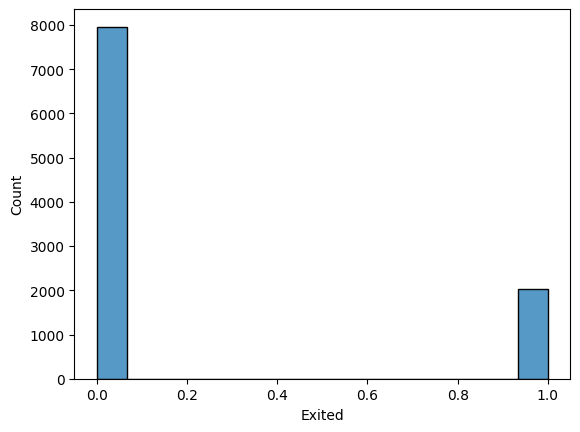

In [7]:
display(df['Exited'].value_counts())
sns.histplot(df['Exited'])
plt.show()

Очевидно, что мы имеем дело с несбалансированным датасетом, наблюдений класса "1" в четыре раза меньше наблюдений класса "0".

In [8]:
# разбиваем на зависимую и независимые переменные
X = df.drop('Exited', axis=1)
y = df['Exited']

# преобразуем категориальные переменные посредством OHE
X = pd.get_dummies(X, columns=categorical, drop_first=True)

# разбиваем на тренировочную и тестовую выборки в соответствии со стратой целевой переменной
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# применяю скейлер после разбивки на тренировочную и тестовую выборки,
# чтобы не допустить утечки в части возможных крайних значений тестовой выборки
scaler = StandardScaler()
X_train[numeric] = scaler.fit_transform(X_train[numeric])
X_test[numeric] = scaler.transform(X_test[numeric])

In [9]:
# обучим модель без учёта дисбаланса
model = LogisticRegression(class_weight=None, random_state=42)
model.fit(X_train, y_train)
print('(Логистическая Регресся) На обучаемой выборке значение статистики f1 - {:.2f}, значение статистики roc_auc - {:.2f}'.format(f1_score(y_train, model.predict(X_train)),
                                                                                                 roc_auc_score(y_train, model.predict(X_train))))
print('(Логистическая Регресся) На тестовой выборке значение статистики f1 - {:.2f}, значение статистики roc_auc - {:.2f}'.format(f1_score(y_test, model.predict(X_test)),
                                                                                                 roc_auc_score(y_test, model.predict(X_test))))

# обучим модель без учёта дисбаланса
model = RandomForestClassifier(class_weight=None, random_state=42)
model.fit(X_train, y_train)
print('(Случайный лес) На обучаемой выборке значение статистики f1 - {:.2f}, значение статистики roc_auc - {:.2f}'.format(f1_score(y_train, model.predict(X_train)),
                                                                                                 roc_auc_score(y_train, model.predict(X_train))))
print('(Случайный лес) На тестовой выборке значение статистики f1 - {:.2f}, значение статистики roc_auc - {:.2f}'.format(f1_score(y_test, model.predict(X_test)),
                                                                                                 roc_auc_score(y_test, model.predict(X_test))))

(Логистическая Регресся) На обучаемой выборке значение статистики f1 - 0.31, значение статистики roc_auc - 0.59
(Логистическая Регресся) На тестовой выборке значение статистики f1 - 0.29, значение статистики roc_auc - 0.58
(Случайный лес) На обучаемой выборке значение статистики f1 - 1.00, значение статистики roc_auc - 1.00
(Случайный лес) На тестовой выборке значение статистики f1 - 0.59, значение статистики roc_auc - 0.72


Касательно логистической регрессии:

Мы можем наблюдать достаточно низкие показатели статистики f1 на обучаемой и на тестовой выборках. Можно предположить, что модель либо недообучена, либо "уперлась" в свои фундаментальные ограничения, либо же (кто бы мог подумать) - не смогла хорошо обучиться в условиях несбалансированных классов.

Касательно случайного леса:

Случайный лес в целом показал себя крайне достойно даже в условиях несбалансированных классов. Однако проблема переобучения (скорее всего из-за отсутсвия ограничений по глубине) безусловно бросается в глаза. Тем более интереснее взглянуть - можно ли улучшить эффективность модели, применя методы борьбы с дисбалансом в классах (в совокупности с тюнингом гиперпараметров).

## Борьба с дисбалансом

Для начала попробуем обойтись "малой кровью" и посмотреть получится ли достичь целевого значения статистики f1 изменяя веса классов. В рассматриваемых моделях (LogisticRegression, RandomForestClassifier, AdaBoostClassifier со случайным лесов в качестве базовой модели) выставим значения параметра class_weight равным 'balanced'. Так же проведем поиск подходящих гиперпараметров моделей (ну или хотя бы их околооптимальных значений) с помощью GridSearсh и кросс-валидации.

In [10]:
%%time
model_types = {'logreg':LogisticRegression,
               'randfst': RandomForestClassifier,
               'adaboost': AdaBoostClassifier,
               'sgd': SGDClassifier
              }

models_params = {'logreg': {'class_weight': ['balanced'],
                            'C': [0.1, 1],
                            'n_jobs': [-1]},
                 'randfst': {'class_weight':['balanced'],
                             'n_estimators': np.arange(50, 100+1, 30),
                             'max_depth': np.arange(7, 20+1, 1),
                             'n_jobs': [-1]},
                 'adaboost': {'base_estimator': [RandomForestClassifier(class_weight='balanced',
                                                                       n_estimators=30,
                                                                       max_depth=10,
                                                                       n_jobs=-1,
                                                                       random_state=42)],
                              'n_estimators': np.arange(10, 20+1, 5),
                              'learning_rate': [0.1, 1]},
                 'sgd': {'class_weight': ['balanced'],
                         'alpha': [0.00001, 0.0001, 0.001]}
                }

best_models = {}

for model_type in model_types:
    model = model_types[model_type](random_state=42)
    grid = GridSearchCV(model, models_params[model_type], cv=5, scoring=['f1', 'roc_auc'],
                        n_jobs=5, refit='f1', return_train_score=False)
    grid.fit(X_train, y_train)
    best_models[model_type] = grid.best_estimator_
    print('Лучшая модель в группе {} имеет значение статистики f1 - {:.2f}, статистики auc_score - {:.2f} и параметры {}'.format(model_type,
                                                                                                                                 grid.best_score_,
                                                                                                                                 grid.cv_results_['mean_test_roc_auc'][grid.best_index_],
                                                                                                                                 grid.best_params_))
    print()

Лучшая модель в группе logreg имеет значение статистики f1 - 0.48, статистики auc_score - 0.76 и параметры {'C': 0.1, 'class_weight': 'balanced', 'n_jobs': -1}

Лучшая модель в группе randfst имеет значение статистики f1 - 0.62, статистики auc_score - 0.85 и параметры {'class_weight': 'balanced', 'max_depth': 8, 'n_estimators': 50, 'n_jobs': -1}

Лучшая модель в группе adaboost имеет значение статистики f1 - 0.62, статистики auc_score - 0.86 и параметры {'base_estimator': RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=30,
                       n_jobs=-1, random_state=42), 'learning_rate': 0.1, 'n_estimators': 10}

Лучшая модель в группе sgd имеет значение статистики f1 - 0.49, статистики auc_score - 0.76 и параметры {'alpha': 0.001, 'class_weight': 'balanced'}

CPU times: user 3.62 s, sys: 512 ms, total: 4.14 s
Wall time: 29.2 s


Что ж, нам удалось достичь необходимого значения статистики f1 (и даже несколько ее улучшить у такой сложной модели как случайный лес) с использованием "корректировки весов" в моделях. Для  полноты проекта все же посмотрим на поведение моделей на "апсемпленных" данных. Также очевидно, что в одновременной балансировке классов силами моделей - нет необходимости.

In [11]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = np.concatenate([features_zeros] + [features_ones] * repeat)
    target_upsampled = np.concatenate([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=42)
    
    return features_upsampled, target_upsampled

In [12]:
# семплированные версии обучаемых выборок
X_train_up, y_train_up = upsample(X_train, y_train, 4)

In [13]:
%%time
model_types = {'logreg':LogisticRegression,
               'randfst': RandomForestClassifier,
               'adaboost': AdaBoostClassifier,
               'sgd': SGDClassifier               
              }

models_params = {'logreg': {'class_weight': [None],
                            'C': [0.1, 1],
                            'n_jobs': [-1]},
                 'randfst': {'class_weight':[None],
                             'n_estimators': np.arange(50, 100+1, 30),
                             'max_depth': np.arange(7, 20+1, 1),
                             'n_jobs': [-1]},
                 'adaboost': {'base_estimator': [RandomForestClassifier(class_weight=None,
                                                                       n_estimators=30,
                                                                       max_depth=10,
                                                                       n_jobs=-1,
                                                                       random_state=42)],
                              'n_estimators': np.arange(10, 20+1, 5),
                              'learning_rate': [0.1, 1]},
                 'sgd': {'class_weight': [None],
                         'alpha': [0.00001, 0.0001, 0.001]}
                }

best_models_upsampled = {}

for model_type in model_types:
    model = model_types[model_type](random_state=42)
    grid = GridSearchCV(model, models_params[model_type], cv=5, scoring=['f1', 'roc_auc'],
                        n_jobs=5, refit='f1', return_train_score=False)
    grid.fit(X_train_up, y_train_up)
    best_models_upsampled[model_type] = grid.best_estimator_
    print('Лучшая модель в группе {} имеет значение статистики f1 - {:.2f}, статистики auc_score - {:.2f} и параметры {}'.format(model_type,
                                                                                                                                 grid.best_score_,
                                                                                                                                 grid.cv_results_['mean_test_roc_auc'][grid.best_index_],
                                                                                                                                 grid.best_params_))
    print()

Лучшая модель в группе logreg имеет значение статистики f1 - 0.70, статистики auc_score - 0.76 и параметры {'C': 0.1, 'class_weight': None, 'n_jobs': -1}

Лучшая модель в группе randfst имеет значение статистики f1 - 0.96, статистики auc_score - 1.00 и параметры {'class_weight': None, 'max_depth': 19, 'n_estimators': 50, 'n_jobs': -1}

Лучшая модель в группе adaboost имеет значение статистики f1 - 0.97, статистики auc_score - 1.00 и параметры {'base_estimator': RandomForestClassifier(max_depth=10, n_estimators=30, n_jobs=-1,
                       random_state=42), 'learning_rate': 1, 'n_estimators': 20}

Лучшая модель в группе sgd имеет значение статистики f1 - 0.70, статистики auc_score - 0.76 и параметры {'alpha': 0.001, 'class_weight': None}

CPU times: user 9.27 s, sys: 530 ms, total: 9.8 s
Wall time: 37.2 s


Показатели статистики f1 значительно выше, однако сравнивать указанные показатели напрямую было бы несколько опрометчиво, так как технически они производятся на разных выборках. Таким образом, наиболее результативную модель по статистике f1 можно будет определить только на тестовой выборке.

## Тестирование модели

[Баланс весами классов] Модель группы logreg продемонстрировала точность на тестовой выборке статистики f1 - 0.52, статистики auc_score - 0.72


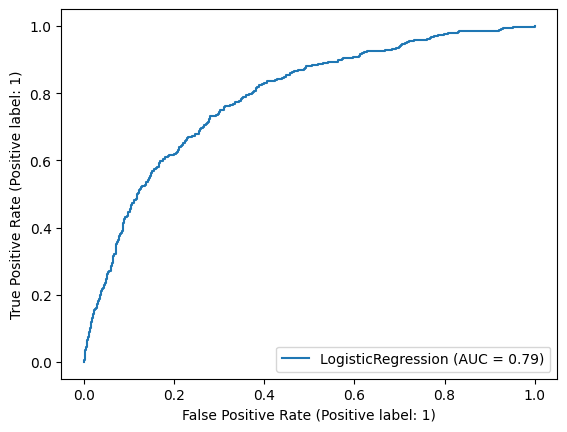

[Баланс весами классов] Модель группы randfst продемонстрировала точность на тестовой выборке статистики f1 - 0.62, статистики auc_score - 0.78


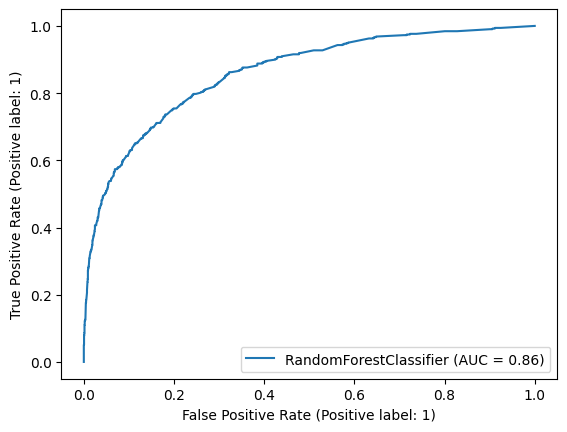

[Баланс весами классов] Модель группы adaboost продемонстрировала точность на тестовой выборке статистики f1 - 0.64, статистики auc_score - 0.78


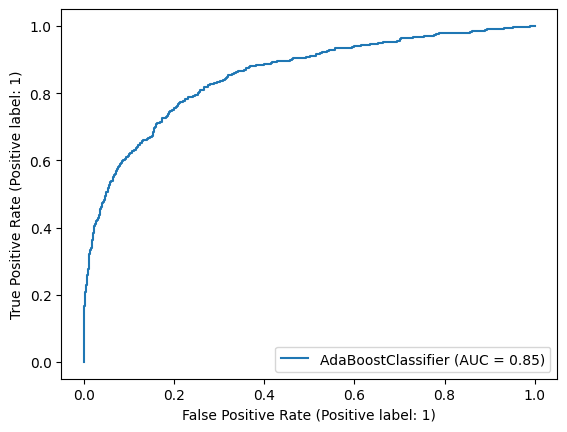

[Баланс весами классов] Модель группы sgd продемонстрировала точность на тестовой выборке статистики f1 - 0.50, статистики auc_score - 0.71


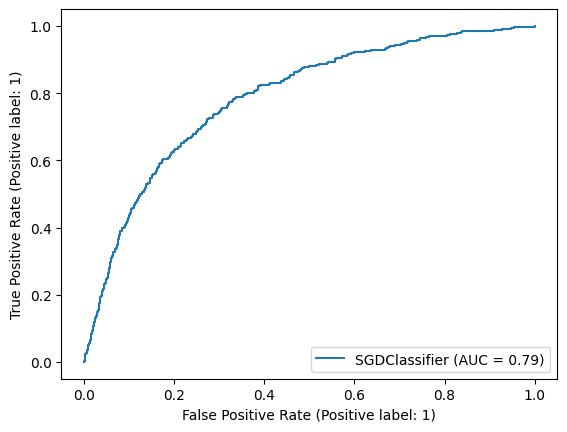

[Upsampling] Модель группы logreg продемонстрировала точность на тестовой выборке статистики f1 - 0.51, статистики auc_score - 0.72


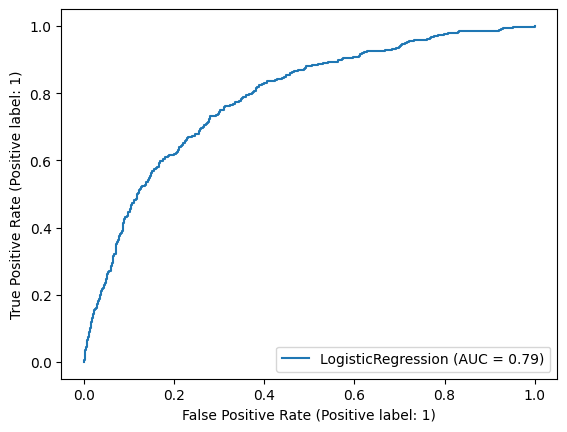

[Upsampling] Модель группы randfst продемонстрировала точность на тестовой выборке статистики f1 - 0.62, статистики auc_score - 0.75


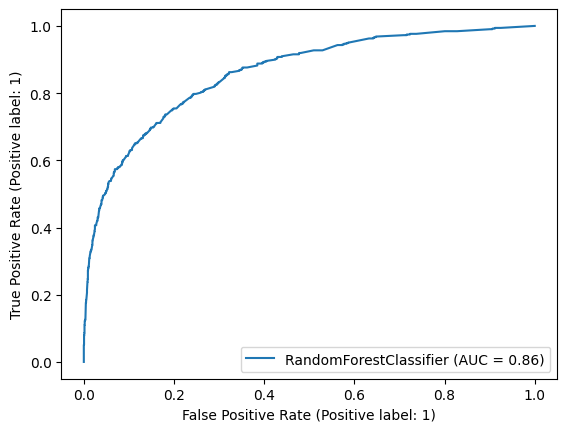

[Upsampling] Модель группы adaboost продемонстрировала точность на тестовой выборке статистики f1 - 0.59, статистики auc_score - 0.73


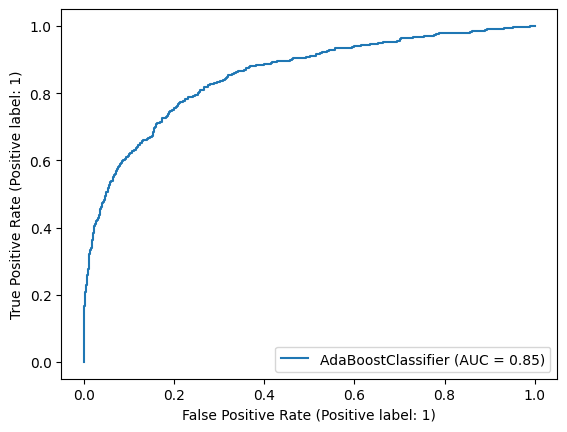

[Upsampling] Модель группы sgd продемонстрировала точность на тестовой выборке статистики f1 - 0.51, статистики auc_score - 0.72


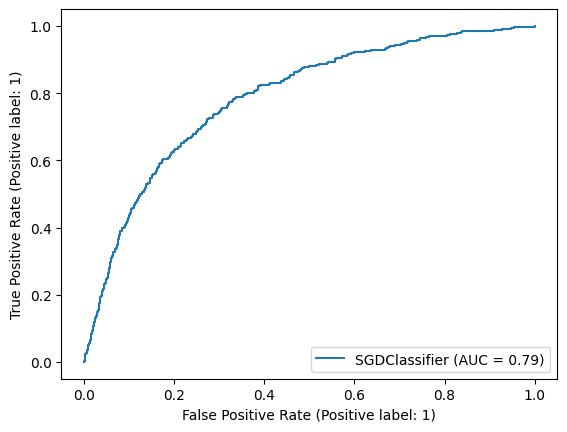

In [14]:
for model in best_models:
    print('[Баланс весами классов] Модель группы {} продемонстрировала точность на тестовой выборке статистики f1 - {:.2f}, статистики auc_score - {:.2f}'\
          .format(model,
                  f1_score(y_test, best_models[model].predict(X_test)),
                  roc_auc_score(y_test, best_models[model].predict(X_test))))
    plot_roc_curve(best_models_upsampled[model], X_test, y_test)
    plt.show()
    
for model in best_models_upsampled:
    print('[Upsampling] Модель группы {} продемонстрировала точность на тестовой выборке статистики f1 - {:.2f}, статистики auc_score - {:.2f}'\
          .format(model,
                  f1_score(y_test, best_models_upsampled[model].predict(X_test)),
                  roc_auc_score(y_test, best_models_upsampled[model].predict(X_test))))
    plot_roc_curve(best_models_upsampled[model], X_test, y_test)
    plt.show()
    

Результаты, продемонстрированные при кросс-валидации полностью оправдались. В целом весовое масштабирование и апсэмпелинг сработали одинаково хорошо, показав сопоставимые (порой даже идентичные) результаты.